In [27]:
import sys
import os
from os import path
import logging
import time

import numpy as np
import open3d as o3d
from IPython.display import Image
sys.path.insert(0, '../../../')

THIS_DIR = path.dirname(path.realpath(os.getcwd()))
PCD_DIR = path.join(THIS_DIR, '..', '..', 'fixtures', 'pcd')
SRC_DOCS = os.path.realpath(os.path.join(os.getcwd(), '..', '..', '..', 'src_docs', '_static' ))

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("PPB")
logger.setLevel(logging.INFO)

from examples.python.utility.helper import load_pcd_file, create_mesh_from_organized_point_cloud_with_o3d, laplacian_opc_cuda
from examples.python.utility.o3d_util import plot_meshes

# Example Point Cloud

Note that `pc` is a N X 3 Numpy array, while `pc_image` is a M X N X 3 organized point cloud

In [5]:
mesh_file = path.join(PCD_DIR, 'pc_01.pcd')
pc, pc_image = load_pcd_file(
    mesh_file, stride=2)
pc_xyz = np.ascontiguousarray(pc[:, :3])
pc_xyz

array([[ 1.37309742, -0.96145308, -0.96777892],
       [ 1.4282397 , -0.98969793, -1.0032233 ],
       [ 1.43046403, -0.98092669, -1.00140643],
       ...,
       [ 3.00140142,  2.0366888 ,  2.08402252],
       [ 3.00092793,  2.05785728,  2.09065151],
       [ 3.00051689,  2.07920647,  2.09741902]])

## Visualize Point Cloud and Mesh

In [10]:
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pc_xyz))
_, tri_mesh_noisy_o3d = create_mesh_from_organized_point_cloud_with_o3d(np.ascontiguousarray(pc_xyz[:, :3]))
plot_meshes([pcd, tri_mesh_noisy_o3d])

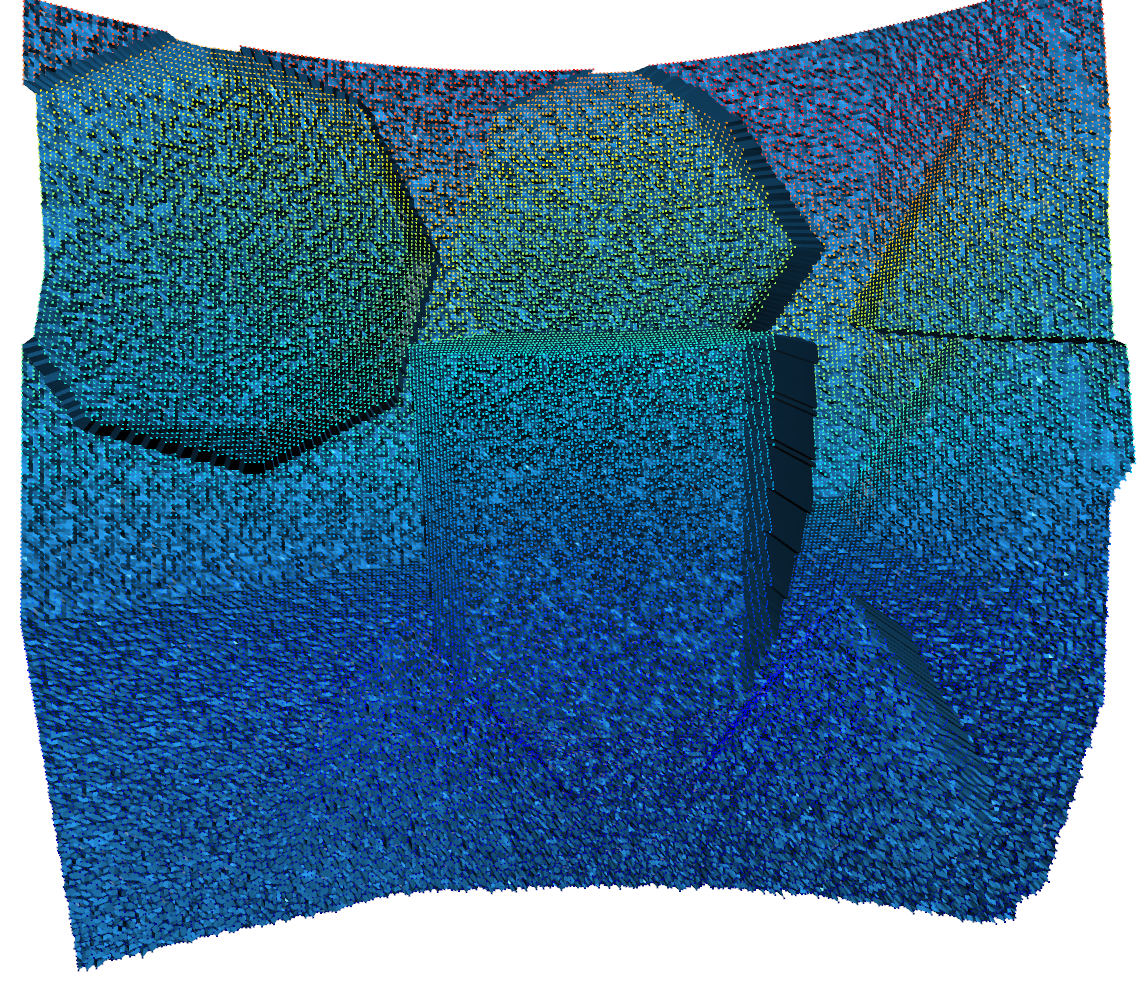

In [15]:
Image(f"{SRC_DOCS}/tutorial/noisy_mesh_pcd.png")

# Laplacian Smoothing

First we import the organized point filter module `opf` and our type conversion class from numpy `Matrix3fRef`. Then we created a simple helper function called `laplacian_opc`.

The function first converts from F64 to F32 floating point type (thats all that is handled currently). Next it wraps the F32 numpy array using `Matrix3fRef` (no copy) such that our C++ Module can understand it.
Then it calls `opf.filter.laplacian_K3` or `K5` depending on the kernel size. Afterward it converts back to F64. 

Note that if your data is already in F32 you don't need any of these conversions.

In [25]:
import organizedpointfilters as opf
from organizedpointfilters import Matrix3fRef

def laplacian_opc(opc, loops=5, _lambda=0.5, kernel_size=3, **kwargs):
    """Performs Laplacian Smoothing on an organized point cloud

    Arguments:
        opc {ndarray} -- Organized Point Cloud MXNX3, Assumed F64

    Keyword Arguments:
        loops {int} -- How many iterations of smoothing (default: {5})
        _lambda {float} -- Weight factor for update (default: {0.5})
        kernel_size {int} -- Kernel Size (How many neighbors to intregrate) (default: {3})

    Returns:
        ndarray -- Smoothed Point Cloud, MXNX3, F64
    """
    opc_float = (np.ascontiguousarray(opc[:, :, :3])).astype(np.float32)

    a_ref = Matrix3fRef(opc_float)

    t1 = time.perf_counter()
    if kernel_size == 3:
        b_cp = opf.filter.laplacian_K3(a_ref, _lambda=_lambda, iterations=loops, **kwargs)
    else:
        b_cp = opf.filter.laplacian_K5(a_ref, _lambda=_lambda, iterations=loops, **kwargs)
    t2 = time.perf_counter()
    logger.info("OPC Mesh Smoothing Took (ms): %.2f", (t2 - t1) * 1000)

    opc_float_out = np.asarray(b_cp)
    opc_out = opc_float_out.astype(np.float64)

    return opc_out

In [20]:
kwargs = dict(loops=5, _lambda=1.0, kernel_size=3)
opc_smooth = laplacian_opc(pc_image, **kwargs, max_dist=0.25)
_, tri_mesh_opc_o3d = create_mesh_from_organized_point_cloud_with_o3d(opc_smooth)
o3d.visualization.draw_geometries([tri_mesh_opc_o3d, pcd])

INFO:PPB:OPC Mesh Smoothing Took (ms): 10.68


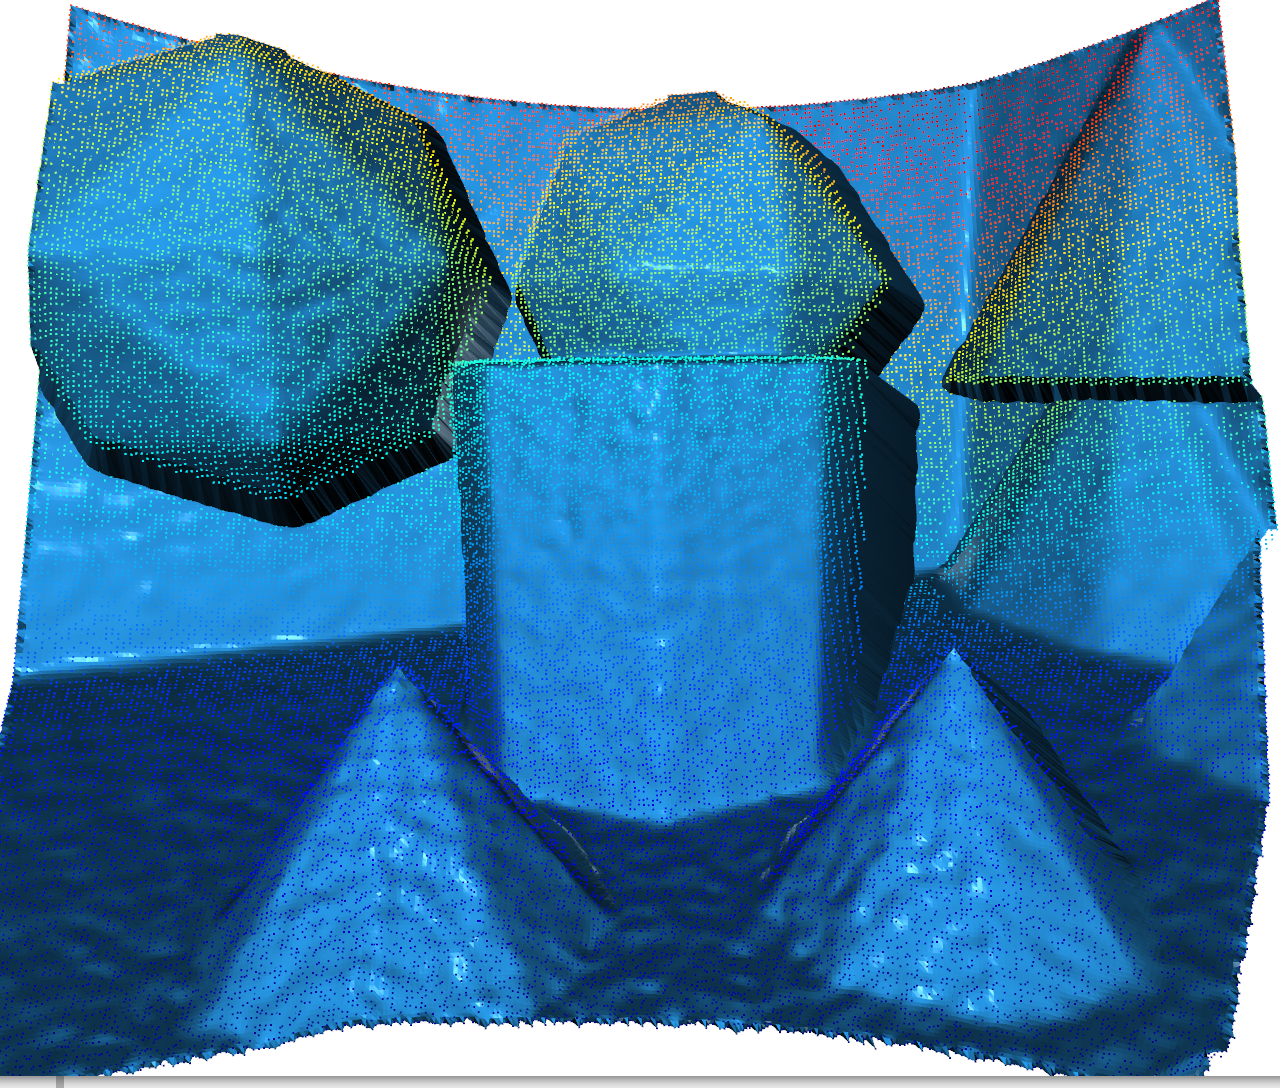

In [21]:
Image(f"{SRC_DOCS}/tutorial/laplacian_mesh_pcd.png")

# Bilateral Smoothing

Bilateral smoothing works on triangle **normals** of the mesh.  Vertex updating is not implemented. The mesh needs to already be *sufficiently smooth*. For example we will be applying bilateral smoothing *after* Laplacian smoothing.

Here is a helper function that performs conversions as before. Note that the return type is an (M-1) X (N-1) X 2 X 3 numpy array. Basically every 2 X 2 quad in the OPC creates *two* implicit triangles:
```
 * O = Point
 *
 *                  O----------------------O
 *                  |                    XX|
 *                  |  TRI 0          XXX  |
 *                  |              XXXX    |
 *                  |            XXX       |
 *                  |         XXX          |
 *                  |       XXX            |
 *                  |     XXX       TRI 1  |
 *                  |   XXX                |
 *                  |XXX                   |
 *                  O----------------------O

```

Therefore we return the (M-1) X (N-1) * 2 triangle normals in mesh

In [23]:
def bilateral_opc(opc, loops=5, sigma_length=0.1, sigma_angle=0.261, **kwargs):
    """Performs bilateral normal smoothing on a mesh implicit from an organized point

    Arguments:
        opc {ndarray} -- Organized Point Cloud MXNX3, Assumed Float 64

    Keyword Arguments:
        loops {int} -- How many iterations of smoothing (default: {5})
        sigma_length {float} -- Saling factor for length (default: {0.1})
        sigma_angle {float} -- Scaling factor for angle (default: {0.261})

    Returns:
        ndarray -- MXNX2X3 Triangle Normal Array, Float 64
    """
    opc_float = (np.ascontiguousarray(opc[:, :, :3])).astype(np.float32)

    a_ref = Matrix3fRef(opc_float)

    t1 = time.perf_counter()
    normals = opf.filter.bilateral_K3(a_ref, iterations=loops, sigma_length=sigma_length, sigma_angle=sigma_angle)
    t2 = time.perf_counter()
    logger.info("OPC Bilateral Filter Took (ms): %.2f", (t2 - t1) * 1000)
    normals_float_out = np.asarray(normals)
    normals_out = normals_float_out.astype(np.float64)

    return normals_out

In [28]:
# Bilateral Filter on NORMALS [CPU](using the already smoothed VERTICES)
kwargs_bilateral = dict(loops=5, sigma_length=0.1, sigma_angle=0.261)
opc_normals_smooth = bilateral_opc(opc_smooth, **kwargs_bilateral)
# opc_normals_smooth must be reshaped from an "image" to a flat NX3 array for Open3D
total_triangles = int(opc_normals_smooth.size / 3)
opc_normals_smooth = opc_normals_smooth.reshape((total_triangles, 3))
# Create new Open3D mesh with these triangle normals
tri_mesh_smoothed_normal_o3d = o3d.geometry.TriangleMesh(tri_mesh_opc_o3d)
tri_mesh_smoothed_normal_o3d.triangle_normals = o3d.utility.Vector3dVector(opc_normals_smooth)
# visualize
o3d.visualization.draw_geometries([tri_mesh_smoothed_normal_o3d, pcd])

INFO:PPB:OPC Bilateral Filter Took (ms): 26.97


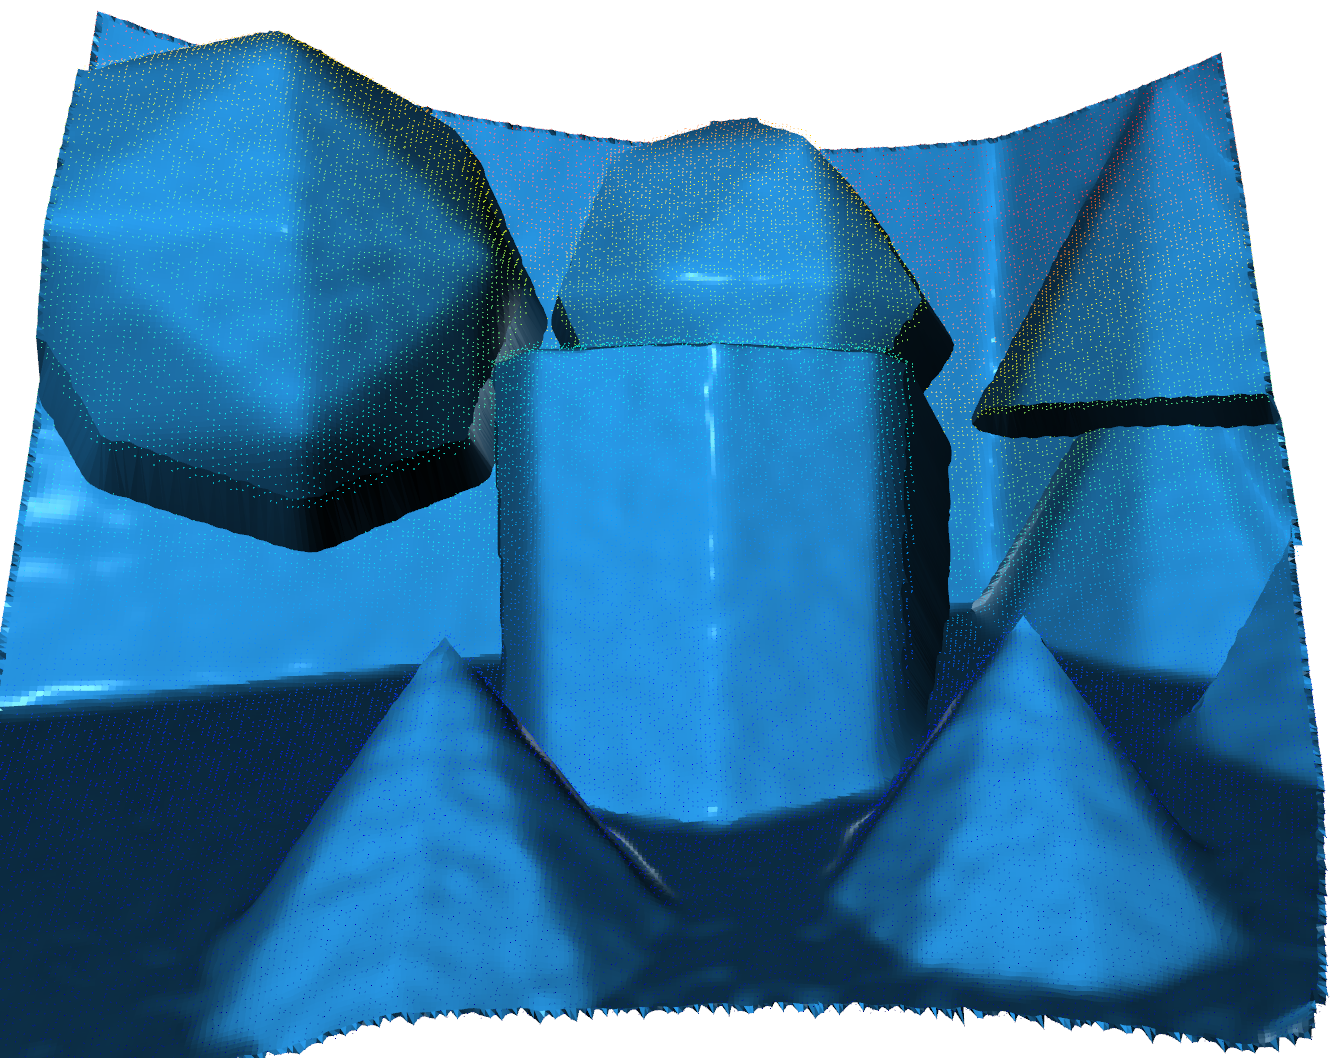

In [30]:
Image(f"{SRC_DOCS}/tutorial/bilateral_mesh_pcd.png")

# GPU Acceleration 

GPU Accelerated implementation of these filters are created as well. They currently only work on CUDA and have been tested on a NVIDIA 2070 Super. These filters are in the module `opf.cuda.kernel` and rely upon [cupy](https://cupy.chainer.org/).
To see some of these in action please see the `examples/python` folder.